# Evaluating how well NFL Teams Draft Talent

In this notebook I'm going to be using data scraped from pro-football-reference.com to evaluate how NFL teams perform at drafting talent. 

In [77]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker,
    PrintfTickFormatter,
    ColorBar,
)
from bokeh.plotting import figure

I use this function to scrape and clean draft data from PFR. 

In [78]:
def scrapeDraftData(start, end):
    urlprefix = 'https://www.pro-football-reference.com/years/'
    urlend = '/draft.htm'
    
    # will be filling in and returning this guy
    master = pd.DataFrame()
    
    for year in range(start, end + 1):
        url = urlprefix + str(year) + urlend
        html = urlopen(url).read()
        soup = BeautifulSoup(html, 'lxml')
        
        column_headers = [th.getText() for th in 
                         soup.findAll('tr', limit=2)[1].findAll('th')]
        
        data_rows = soup.findAll('tr')[2:]
        
        # why do we look for both 'th' and 'td'? Because PFR uses the 'th' tag
        # for the round in its tables
        draft_data = [[td.getText() for td in data_rows[i].findAll(['th', 'td'])]
                     for i in range(len(data_rows))]
        
        df = pd.DataFrame(draft_data, columns = column_headers)
        
        # having gotten a year of draft data, begin janitoring.
        # first task? For comprehensibility on the site PFR repeats
        # table headers after each round. But they are easily detected
        df = df[df.Rnd != 'Rnd']

        # add a column for year; make it the first column
        df.insert(loc=0, column='Year', value = year)
        
        # last column just has a link to college stats; don't care
        df = df.drop(labels='', axis=1)
        
        # need to rename a bunch of columns
        # could do this in place but there's sufficiently many that it's 
        # worth doing in bulk
        df.columns = ['Year', 
                      'Round',
                      'Pick',
                      'Team',
                      'Player',
                      'Position',
                      'Age',
                      'To', # table records last year player played
                      'AP1', # first team all pro selections
                      'PB', #pro bowl appearances
                      'St', # years as a starter
                      'CarAV',
                      'DrAV',
                      'Games',
                      'Pass_Cmp', #passing stats here
                      'Pass_Att',
                      'Pass_Yds',
                      'Pass_TD',
                      'Pass_Int',
                      'Rush_Att', #rushing stats here
                      'Rush_Yds',
                      'Rush_TD',
                      'Rec', #receiving stats
                      'Rec_Yds',
                      'Rec_TD',
                      'Def_Tkl', #defensive stats
                      'Def_Int',
                      'Def_Sk',
                      'College/Univ']
        
        # convert stuff 
        # TODO: deprecated; should fix this later
        df = df.convert_objects(convert_numeric = True)
        
        # Missing values should just be zero
        df = df[:].fillna(0)
        
        # more bits of cleaning I've encountered along the way
        df = df[df.Team != 0]
        df = df[df.Team != '']

        
        master = master.append(df, ignore_index = True)
    
    return master

In [79]:
try:
    df_draft = pd.read_csv('Draft_data_2010_2017.csv')
except FileNotFoundError:
    # hit PFR for data
    df_draft = scrapeDraftData(2010, 2017)
    df_draft.to_csv('Draft_data_2010_2017.csv')

In [80]:
df_draft[['Year', 'Pick', 'Team', 'Player', 'Position', 'CarAV', 'DrAV']].head()

,Year,Pick,Team,Player,Position,CarAV,DrAV
0,2010,1.0,STL,Sam Bradford,QB,43.0,23.0
1,2010,2.0,DET,Ndamukong Suh,DT,79.0,58.0
2,2010,3.0,TAM,Gerald McCoy,DT,61.0,61.0
3,2010,4.0,WAS,Trent Williams,T,61.0,61.0
4,2010,5.0,KAN,Eric Berry,DB,48.0,48.0


For purposes of analysis, I'm going to be evaluating players using a metric created by PFR called Approximate Value (AV). More about AV can be found [https://www.pro-football-reference.com/blog/index37a8.html]here. Why AV and not some other metric (DYAR, PFF grades, something homebrew)? Because AV is already in the data I scraped from PFR and I don't believe in reinventing the wheel. AV may not be perfect, but no metric is. 

PFR data include two AV metrics, displayed above. CarAV is Career AV, and accumulates for a player over the course of his career. DrAV is the AV a player accumulated while playing for the team that drafted him. For instance, note that Sam Bradford's CarAV and DrAV are different, this is because he played only a portion of his career for the team that drafted him (the Rams). On the other hand, Gerald McCoy's CarVA and DrAV are equal, indicating he's played his entire career for Tampa Bay. 

This also highlights a bit of data janitoring I need to do. Note that Sam Bradford's team is coded as 'STL', which is the Saint Louis Rams. The Rams are no longer in St. Louis, having moved to LA two years ago. Likewise the San Diego Chargers also now play in LA. For purposes of this analysis, I prefer to maintain continuity across the teams.

In [81]:
df_draft.loc[df_draft['Team'] == 'STL','Team'] = 'LAR'
df_draft.loc[df_draft['Team'] == 'SDG','Team'] = 'LAC'
df_draft[['Year', 'Pick', 'Team', 'Player', 'Position', 'CarAV', 'DrAV']].head()

,Year,Pick,Team,Player,Position,CarAV,DrAV
0,2010,1.0,LAR,Sam Bradford,QB,43.0,23.0
1,2010,2.0,DET,Ndamukong Suh,DT,79.0,58.0
2,2010,3.0,TAM,Gerald McCoy,DT,61.0,61.0
3,2010,4.0,WAS,Trent Williams,T,61.0,61.0
4,2010,5.0,KAN,Eric Berry,DB,48.0,48.0


There are two ways to consider how well a team has drafted. First, I can look at the total AV a team receieved in each draft.

In [82]:
df_draft[df_draft.Year == 2013].groupby('Team').CarAV.sum().sort_values(ascending=False).head()

Team
GNB    155.0
DET    147.0
PIT    118.0
ARI    114.0
PHI    111.0
Name: CarAV, dtype: float64

This is in a sense the total value provided by the players drafted by each team in 2013. By this metric, it seems that Green Bay and Detroit did especially well that year. But that's not the whole story! For starters, teams do not have the same number of picks, both within and across drafts. Picks can be traded (for players, or for other picks), teams can be granted so-called 'compensatory' picks for losing players to free agency, and can even have picks taken away as a disciplinary action. In order to understand how well teams have done, one thing we can do is look at the "average" AV generated by players a team drafted. 

In [83]:
df_draft[df_draft.Year == 2013].groupby('Team').CarAV.mean().sort_values(ascending=False).head()

Team
NOR    17.400000
CAR    16.800000
DET    16.333333
CHI    16.000000
LAC    15.333333
Name: CarAV, dtype: float64

Note that these two lists do not in general resemble one another! While players drafted by Green Bay in 2013 generated the most value in total, New Orleans was more efficient in using its picks. 

This still doesn't tell the whole story. The NFL draft is a sequential process: each team is given a ranking from 1 to 32 based on their performance in the previous season (the worst team gets the first pick; the Super Bowl winner gets the 32nd pick). Assuming teams know what they're doing (which we'll see is a big assumption), it would stand to reason that teams with earlier picks should get the better players. In order to account for this, we need to come up with some way of defining the value a team *should* have gotten given a pick. To wit: I need to construct an estimate of the distribution of approximate value conditioned on pick number for each year. 

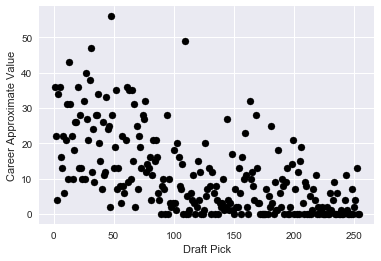

In [84]:
%matplotlib inline

y = df_draft[df_draft.Year == 2013].CarAV.values.reshape(-1,1)
x = np.linspace(1, len(y), len(y))

plt.scatter(x, y, color='black')
plt.xlabel('Draft Pick')
plt.ylabel('Career Approximate Value')
plt.show()

The plot looks about as we'd expect. As I intuited, in general the value generated by a player is declining as he falls in the draft, though there's a high amount of variance (for instance, note that the "best" player in this draft was drafted with a pick above 50, and the second best player was drafted with a pick somewhere around 125). There's also a lot of clustering down toward zero as you get to around the 100th pick, this indicates players who likely didn't play in the league at all. 

In order to evaluate how well teams did with their picks, we have to come up with a notion of how well we'd expect them to do. To do this I want to form the conditional expectation of CarAV given a pick number. While I could just fit a linear regression line to the data, there does seme to be some amount of nonlinearity. If you squint at the data it looks vaguely logistic, but honestly I'm a fan of nonparametric style analysis so I'm going to just fit a spline to this thing. For more splines, go here. 

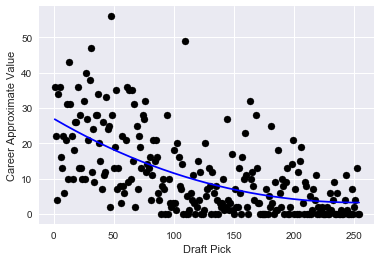

In [85]:
from scipy.interpolate import UnivariateSpline

# the tuning parameter s is not something I understand well! 
s = UnivariateSpline(x, y, s=25000)
yhat = s(x)
plt.scatter(x, y, color='black')
plt.plot(x, yhat, color='b')
plt.xlabel('Draft Pick')
plt.ylabel('Career Approximate Value')
plt.show()

That curve more or less looks reasonable. Points above the curve represent players who exceeded their expectation given their draft position. Points below the curve represent players who fell short. By comparing the distance between the curve and the points above and below it, I can create a metric to measure how well a team did with a given pick. I will call this metric "RV" for residual value.

For example, let's have a look at the 2013 draft (since I've already computed the expected value in the code above).

In [86]:
df_2013 = df_draft[df_draft['Year'] == 2013]
df_2013['RV'] = df_2013['CarAV'] - yhat
df_2013[['Pick', 'Team', 'Player', 'Position', 'CarAV', 'RV']].head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Pick,Team,Player,Position,CarAV,RV
766,1.0,KAN,Eric Fisher,T,36.0,9.184740
767,2.0,JAX,Luke Joeckel,T,22.0,-4.617768
768,3.0,MIA,Dion Jordan,DE,4.0,-22.421190
769,4.0,PHI,Lane Johnson,T,34.0,7.774475
770,5.0,DET,Ezekiel Ansah,DE,36.0,9.969228


From above, we can see that Kansas City, Philadelphia, and Detroit did pretty well with their first picks in 2013. On the other hand, Jacksonville and Miami did poorly. By coincidence, both Luke Joeckel *and* Dion Jordan played for the Seahawks (my team) in 2017. Go Hawks?

Using this metric, I can now estimate which teams were the big winners and losers in the 2013 draft, both on a total basis and on a per-pick basis. 

In [88]:
df_2013.groupby('Team').RV.sum().sort_values(ascending=False).head()

Team
GNB    60.483488
DET    53.524404
CHI    30.858118
NOR    22.319040
PIT    22.223889
Name: RV, dtype: float64

In [89]:
df_2013.groupby('Team').RV.mean().sort_values(ascending=False).head()

Team
DET    5.947156
GNB    5.498499
CHI    5.143020
NOR    4.463808
CAR    3.577278
Name: RV, dtype: float64

These two lists actually do mirror one another pretty well, which is nice. Green Bay and Detroit both killed it in this draft; though Detroit as a bit more efficient. Now what about the losers?

In [90]:
df_2013.groupby('Team').RV.sum().sort_values(ascending=False).tail()

Team
SFO   -29.063554
CLE   -29.799522
SEA   -30.611013
MIA   -35.645488
TEN   -36.601042
Name: RV, dtype: float64

In [107]:
df_2013.groupby('Team').RV.mean().sort_values(ascending=False).tail()

Team
IND   -3.698024
DEN   -3.941630
MIA   -3.960610
TEN   -4.575130
CLE   -5.959904
Name: RV, dtype: float64

As a Seattle fan, it pains me to see them on this list. In fact the 2013 draft was part of the reason I became interested in this project, for reasons that will become clear soon. Along with Seattle, the big losers are a rogue's league of bad teams. In fact in terms of performance, Seattle is a major outlier in that list. Note though that while they did poorly overall, their pick efficiency wasn't bottom-five. So that's nice.

I'm pretty comfortable with this metric, so now it's time to perform it for the larger data set. 

In [92]:
for year in df_draft.Year.unique():
    y = df_draft[df_draft['Year'] == year].CarAV.values.reshape(-1, 1)
    x = np.linspace(1, len(y), len(y))
    s = UnivariateSpline(x, y, s=25000)
    yhat = s(x)
    df_draft.loc[df_draft['Year'] == year,'RV'] = df_draft[df_draft['Year'] == year].CarAV - yhat

Having done this, let me look at how teams have done overall for the eight-year period 2010-2017:

In [93]:
RV_total = df_draft.groupby('Team').RV.sum().sort_values(ascending=False)
RV_mean = df_draft.groupby('Team').RV.mean().sort_values(ascending=False)
df_RV = pd.concat([RV_total, RV_mean], axis=1)
df_RV.columns = ['Total RV', 'RV per pick']

In [94]:
df_RV.sort_values(by='Total RV', ascending=False).head()

,Total RV,RV per pick
SEA,144.295433,1.873967
GNB,130.391695,1.862738
DAL,90.341430,1.411585
NOR,73.523362,1.500477
OAK,58.521294,0.860607


It's nice to see Seattle at the top of that list, despite their dreadful 2013 draft. But how did they get up there? To answer that question, I turn to some visualization. First I'm going to build some new dataframes...

In [108]:
column_headers = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
index_ordered = ['BUF', 'MIA', 'NYJ', 'NWE',
               'BAL', 'CIN', 'CLE', 'PIT',
               'IND', 'JAX', 'HOU', 'TEN',
               'DEN', 'KAN', 'LAC', 'OAK',
               'DAL', 'NYG', 'PHI', 'WAS',
               'CHI', 'DET', 'GNB', 'MIN',
               'ATL', 'CAR', 'NOR', 'TAM',
               'ARI', 'LAR', 'SFO', 'SEA']

df_RVSum = pd.concat([df_draft[df_draft['Year'] == year].groupby('Team').RV.sum() for year in df_draft.Year.unique()], axis=1)
df_RVSum.columns = column_headers
df_RVSum = df_RVSum.reindex(index = index_ordered)

df_RVmean = pd.concat([df_draft[df_draft['Year'] == year].groupby('Team').RV.mean()for year in df_draft.Year.unique()], axis=1)
df_RVmean.columns = column_headers
df_RVmean = df_RVmean.reindex(index = index_ordered)

In [170]:
df_RVSum['2017'].sort_values(ascending=False)

Team
NOR    20.180604
LAR     7.036791
CHI     6.479174
SFO     6.409159
JAX     6.261888
HOU     6.047586
MIN     5.361545
KAN     4.777305
DET     4.511635
BUF     4.122439
NYG     3.598191
PIT     3.566808
CAR     0.363574
TAM    -0.059126
NYJ    -0.657526
WAS    -1.230855
ARI    -1.542193
GNB    -1.867180
CIN    -1.966555
DAL    -2.833312
CLE    -3.138732
MIA    -3.189783
OAK    -3.399980
TEN    -4.106102
NWE    -5.277592
LAC    -5.978674
IND    -6.133523
SEA    -6.303343
ATL    -6.347505
PHI    -6.887514
BAL    -8.613826
DEN    -9.183379
Name: 2017, dtype: float64

In [189]:
df_draft[(df_draft.Year == 2017) & (df_draft.Team == 'SEA')][['Pick','Player','RV']]

,Pick,Player,RV
1820,35.0,Malik McDowell,-3.926334
1843,58.0,Ethan Pocic,1.618394
1875,90.0,Shaquill Griffin,1.306580
1880,95.0,Delano Hill,-1.592872
1887,102.0,Nazair Jones,-0.455161
1891,106.0,Amara Darboh,-1.378047
1896,111.0,Tedric Thompson,-1.283247
1972,187.0,Michael Tyson,-1.043838
1995,210.0,Justin Senior,-0.735955
2011,226.0,David Moore,-0.537964


Then I'm going to drop them into a heat map. 

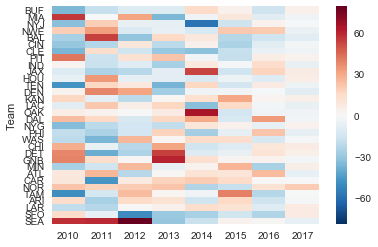

In [109]:
import seaborn as sns

sns.heatmap(df_RVSum, center=-0)

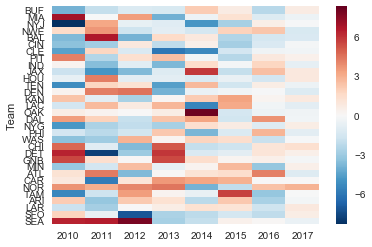

In [110]:
sns.heatmap(df_RVmean, center=0)

As you can see, Seattle was the beast drafting team from 2010-2012, after which they cooled off quite a bit. The 2012 draft in particular was off the charts.

One issue with this heatmap is that in general RV is biased toward zero in more recent draft years. This is an artifact of AV (and thus RV) being a counting stat. Players from earlier drafts have had more seasons to accumulate AV, whether it be positive or negative. I've tried to come up with a way of normalizing to account for this, but I've failed. I could for instance normalize by the number of years in the league, but this tends to bias older draft classes toward zero because of the number of players falling out of the league due to reitrement, injury, etc. In the end I leave it as is, because I think it's reasonable to interpret the paler right side of the heatmap as reflecting less information about players from more recent drafts. 

In [98]:
df_draft[(df_draft.Year == 2012) & (df_draft.Team == 'SEA')][['Pick', 'Position', 'Player', 'CarAV', 'RV']]

,Pick,Position,Player,CarAV,RV
526,15.0,DE,Bruce Irvin,35.0,3.885283
558,47.0,LB,Bobby Wagner,73.0,25.022221
586,75.0,QB,Russell Wilson,88.0,23.211768
617,106.0,RB,Robert Turbin,16.0,4.924183
625,114.0,DT,Jaye Howard,17.0,3.977283
665,154.0,LB,Korey Toomer,11.0,3.545870
683,172.0,DB,Jeremy Lane,11.0,-3.536538
692,181.0,DB,Winston Guy,3.0,-1.527608
736,225.0,DT,J.R. Sweezy,31.0,20.210367
743,232.0,DE,Greg Scruggs,1.0,-1.039311


Hm, this exposes something that's worth looking at in the future: why is Russell Wilson's RV lower than Bobby Wagner's, despite the fact that he was taken thirty picks later? Given that his CarAV is higher, the implication here is that his expected AV was somehow higher, which seems weird. That's a big asterisk for future investigation; I may not be estimating things correctly. Regardless, this is a good draft: lots of players overperformed (Bobby Wagner and Russell Wilson are two of the best players at their positions), and very few underperformed. 

Seattle's huge 2010-2012 followed by a fairly mediocre 2013-2017 leads me to ask: what teams are the most and least consistent in drafting? 

In [99]:
df_RVSum.var(axis=1).sort_values(ascending=True).head()

Team
IND    173.442467
LAR    192.455215
CIN    218.657128
HOU    227.944353
NYG    228.256988
dtype: float64

The Colts have been the most consistent team in their drafts... consistently bad. 

In [100]:
df_RVSum.var(axis=1).sort_values(ascending=False).head()

Team
SEA    1659.132846
BAL     789.304021
MIA     749.667335
TAM     738.187702
JAX     666.677648
dtype: float64

It probably comes as no surprise to anyone who glanced at the heat maps that Seattle is the least consistent team. That 2010-2012 stretch of amazing followed by a mediocre-to-bad 2013-2017 gives them enormous variance. Of course variance of total RV will necessarily be affected by varying number of picks. 

In [101]:
df_RVmean.var(axis=1).sort_values(ascending=True).head()

Team
LAR    2.457440
CIN    2.725653
HOU    3.576157
KAN    3.751948
BUF    3.827330
dtype: float64

In [102]:
df_RVmean.var(axis=1).sort_values(ascending=False).head()

Team
SEA    17.898381
NYJ    12.552327
TAM    12.351032
JAX    12.161387
BAL    12.071434
dtype: float64

On a per-pick basis there's still a huge gap between Seattle and the rest of the league over this time span. 

One thing I'd like to do is dress up that heatmap. Enter Bokeh, a (fairly) new library for data visualization. It's intended to provide d3.js style visualizations with a minimal(ish) amount of effort. 

In [103]:
# get bokeh stuff going
from bokeh.io import show
from bokeh.plotting import figure

from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker,
    PrintfTickFormatter,
    ColorBar,
)

Once upon a time Bokeh had a built-in heatmap chart. It doesn't any more, but it's easy enough to create one following this example; effectively just manually drawing rectangle glyphs on a grid and coloring them in.

One thing to note: While Bokeh can render from a dataframe, it requires that the data be in a specific format. It will not work to just hand it the data frame as is. 

In [111]:
# TODO do I need to do this with the index? 
df_RVSum['Team'] = df_RVSum.index
df_RVSum.columns.name = 'Year'
df_RVSum = df_RVSum.set_index('Team')

df = pd.DataFrame(df_RVSum.stack(), columns=['SumRV']).reset_index()
df.head()

,Team,Year,SumRV
0,BUF,2010,-35.335860
1,BUF,2011,-18.032444
2,BUF,2012,-10.941380
3,BUF,2013,-10.752049
4,BUF,2014,14.819973


In [112]:
years = list(df_RVSum.columns)
teams = list(df_RVSum.index)

colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
mapper = LinearColorMapper(palette=colors, low=df.SumRV.min(), high=df.SumRV.max())

source = ColumnDataSource(df)

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(title="NFL Draft Performance ({0} - {1})".format(years[0], years[-1]),
          x_range = years, y_range = list(reversed(teams)),
          x_axis_location="above", plot_width=900, plot_height=900,
          tools=TOOLS, toolbar_location="below")

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "10pt"
p.axis.major_label_standoff = 0
# p.axis.major_label_orientation = pi / 3

p.rect(x="Year", y="Team", width=1, height=1,
      source=source,
      fill_color={'field': 'SumRV', 'transform': mapper},
      line_color=None)

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="5pt",
                    ticker=BasicTicker(desired_num_ticks=len(colors)),
                    formatter=PrintfTickFormatter(format="%d"),
                    label_standoff=6, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'right')

p.select_one(HoverTool).tooltips = [
    ('Team', '@Team'),
    ('Year', '@Year'),
    ('Total RV', '@SumRV'),
]
show(p)